In [2]:
import numpy as np
import pandas as pd
import math
from givens import givens_rotation
from potters_algorithm import Potter

In [3]:
csv = np.genfromtxt('User1_Pre2.csv', delimiter=",")

# Slice the first column (header)

csv = csv[1:]

eeg = csv[:, [11, 12, 13]]

#eeg = eeg[800:1600]

# convert to df and save to csv
df = pd.DataFrame(eeg)
df.to_csv('eeg.csv', index=False)

In [4]:
def series_taylor(dt, n=2):
    F = np.eye(len(eeg[0]))  # Identity matrix
    A = np.array([[0, 1, 0], [-1, 0, 0], [0, 0, 1]])  # Matrix for system dynamics
    for i in range(0, n+1):
        F += (dt ** i) / math.factorial(i) * np.linalg.matrix_power(A, i)
    return F

def LDLT_decomposition(P):
    L = np.linalg.cholesky(P)
    return L

In [5]:
x_0 = eeg[0, :]
P_0 = np.eye(len(eeg[0]))
H = np.eye(len(eeg[0]))
R = np.array([[0.1, 0, 0], [0, 0.1, 0], [0, 0, 0.1]])

dt = 1 / 128

n_steps = len(eeg)
y = eeg
lista = np.zeros((n_steps, len(eeg[0]))) 

In [6]:
# Initialize state and covariance for t=0
x_t = x_0
S_t = LDLT_decomposition(P_0)
lista[0, :] = x_0  # Store initial state

# Kalman ensemble loop
for i in range(1, n_steps):
    F = series_taylor(dt)  # Update transition matrix
    S_t = givens_rotation(F, np.eye(len(eeg[0])), S_t)  # Apply Givens rotation
    x_t, S_t = Potter(x_t, S_t, y[i], H, R)  # Update state and covariance with Potter
    if i > 790 and i < 800:
        print("Step: " + str(i))
        print("F", F)
        print("S_t", S_t)
        print("x_t", x_t)
        print("y", y[i])
        print("H", H)
    lista[i, :] = x_t  # Store the state estimate

Step: 791
F [[ 1.99996948  0.0078125   0.        ]
 [-0.0078125   1.99996948  0.        ]
 [ 0.          0.          2.00784302]]
S_t [[-7.16687091e-03 -9.54249970e-23 -0.00000000e+00]
 [-8.75390251e-23 -7.16687091e-03 -0.00000000e+00]
 [-0.00000000e+00 -0.00000000e+00 -7.16687671e-03]]
x_t [-5.71391362e-01 -5.30489359e+21  1.97359876e+00]
y [1.4179 5.6748 1.1514]
H [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Step: 792
F [[ 1.99996948  0.0078125   0.        ]
 [-0.0078125   1.99996948  0.        ]
 [ 0.          0.          2.00784302]]
S_t [[-7.16687091e-03 -9.54249970e-23 -0.00000000e+00]
 [-8.75390251e-23 -7.16687091e-03 -0.00000000e+00]
 [-0.00000000e+00 -0.00000000e+00 -7.16687671e-03]]
x_t [ 1.01063801e+00 -5.64443340e+21  1.97237050e+00]
y [3.0619 8.7926 0.9959]
H [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Step: 793
F [[ 1.99996948  0.0078125   0.        ]
 [-0.0078125   1.99996948  0.        ]
 [ 0.          0.          2.00784302]]
S_t [[-7.16687091e-03 -9.54249970e-23 -0.00000000e+00]
 [-

In [7]:
# Convert the state estimates to a DataFrame

df = pd.DataFrame(lista, columns=['F4', 'F8', 'AF4'])
print(df)


                F4            F8       AF4
0     2.165800e+00  4.137600e+00  2.039600
1     1.277070e+00  1.203596e+01  6.840061
2     6.169152e-01 -1.239508e+00  5.053167
3    -1.629691e+00 -1.842568e+00  5.579350
4    -2.079491e+00 -1.137330e+00  5.585594
...            ...           ...       ...
3067  1.253418e+61 -1.118107e+83  0.281220
3068  1.333643e+61 -1.189671e+83  0.282338
3069  1.419002e+61 -1.265816e+83  0.279893
3070  1.509826e+61 -1.346835e+83  0.277236
3071  1.606462e+61 -1.433039e+83  0.277142

[3072 rows x 3 columns]


In [8]:
# Save the DataFrame to a CSV file
df.to_csv('kalman.csv', index=False)


F4     float64
F8     float64
AF4    float64
dtype: object


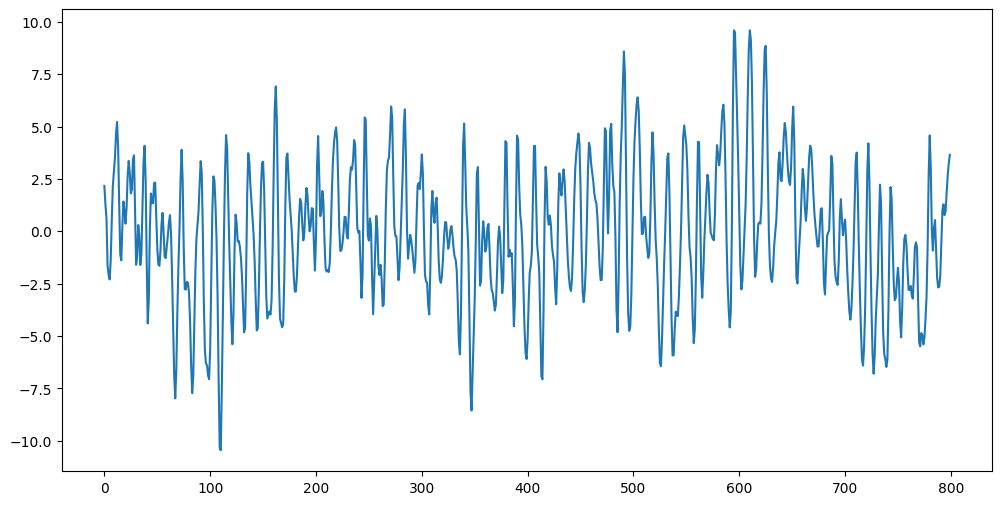

In [9]:
# Plot each channel
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('kalman.csv')

# Data to 4 decimal places
df = df.round(4)

# Print the first few rows
print(df.dtypes)

# Plot each channel
plt.figure(figsize=(12, 6))
plt.plot(df['F4'][:800], label='F4')

        0        1       2
0  2.1658   4.1376  2.0396
1  1.9520   7.1215  5.7523
2  1.0845   5.3174  4.4058
3 -0.6902  -2.3976 -1.2643
4 -2.5998 -10.5743 -5.8005


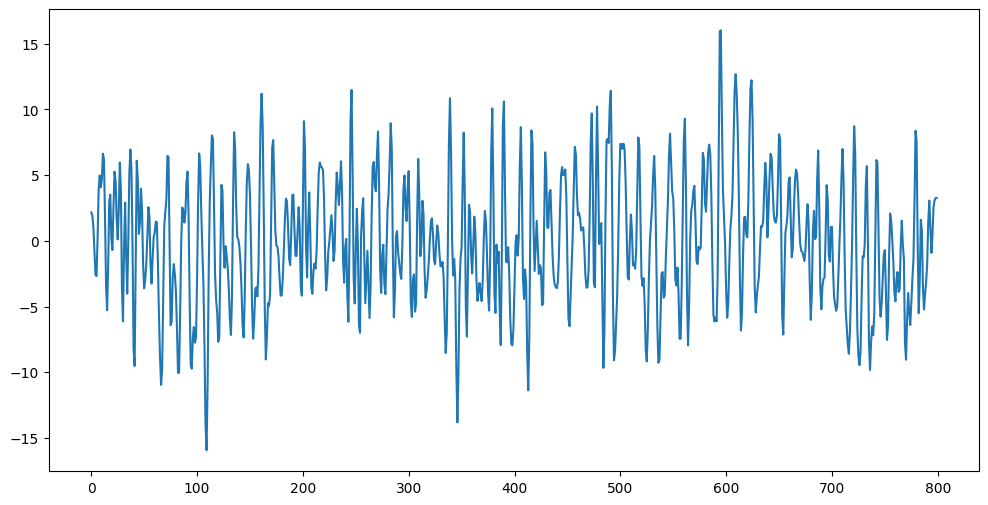

In [10]:
# Read the CSV file
df2 = pd.read_csv('eeg.csv')

# Print head of the DataFrame
print(df2.head())

# Plot each channel
plt.figure(figsize=(12, 6))
plt.plot(df2['0'][:800], label='F4')